This portion contains other exercises that previous file couldnt run

****Exercise 7****

In [1]:
from sklearn.datasets import fetch_kddcup99
D=fetch_kddcup99()

In [2]:
dir(D)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [3]:
print(D["DESCR"])

.. _kddcup99_dataset:

Kddcup 99 dataset
-----------------

The KDD Cup '99 dataset was created by processing the tcpdump portions
of the 1998 DARPA Intrusion Detection System (IDS) Evaluation dataset,
created by MIT Lincoln Lab [2]_. The artificial data (described on the `dataset's
homepage <https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html>`_) was
generated using a closed network and hand-injected attacks to produce a
large number of different types of attack with normal activity in the
background. As the initial goal was to produce a large training set for
supervised learning algorithms, there is a large proportion (80.1%) of
abnormal data which is unrealistic in real world, and inappropriate for
unsupervised anomaly detection which aims at detecting 'abnormal' data, i.e.:

* qualitatively different from normal data
* in large minority among the observations.

We thus transform the KDD Data set into two different data sets: SA and SF.

* SA is obtained by simply selecting all

In [5]:
dir(D)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [7]:
import numpy as np
np.unique(D["target"])

array([b'back.', b'buffer_overflow.', b'ftp_write.', b'guess_passwd.',
       b'imap.', b'ipsweep.', b'land.', b'loadmodule.', b'multihop.',
       b'neptune.', b'nmap.', b'normal.', b'perl.', b'phf.', b'pod.',
       b'portsweep.', b'rootkit.', b'satan.', b'smurf.', b'spy.',
       b'teardrop.', b'warezclient.', b'warezmaster.'], dtype=object)

In [9]:
len(np.unique(D["target"]))

23

In [11]:
D["feature_names"]

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [15]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

D = fetch_kddcup99(as_frame=True) 
data = D.frame

X = data.iloc[:,:-1] 
y = data.iloc[:,-1] 

categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Standardize the features in X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode categorical target y if necessary
if y.dtype == 'object' or isinstance(y[0], bytes):
    le = LabelEncoder()
    y = le.fit_transform(y)

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
D = fetch_kddcup99(subset = 'SA', as_frame=True)
data = D.frame

X = data.iloc[:,:-1] # all cols except last, all rows
y = data.iloc[:,-1] # only last col, all rows

categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Standardize the features in X
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

# Create a subsample of 250 data points
X_subsample, _, y_subsample, _ = train_test_split(X, y, train_size=250, random_state=42)
y_subsample = np.array(y_subsample)

anomaly_algorithms = {
    'IsolationForest': IsolationForest(contamination=0.01, random_state=42),
    'OneClassSVM': OneClassSVM(nu=0.01, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
}

In [19]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize Leave-One-Out cross-validation
loo = LeaveOneOut()

# Train and evaluate anomaly detection algorithms
anomaly_results = {}
for algo_name, algo in anomaly_algorithms.items():
    print(f"Evaluating {algo_name} with Leave-One-Out cross-validation...")
    
    y_true = []
    y_pred = []
    
    for train_index, test_index in loo.split(X_subsample):
        X_train, X_test = X_subsample[train_index], X_subsample[test_index]
        y_train, y_test = y_subsample[train_index], y_subsample[test_index]
        
        if algo_name == 'LocalOutlierFactor':
            algo.fit(X_train)
            y_pred_test = algo.predict(X_test)
        else:
            algo.fit(X_train)
            y_pred_test = algo.predict(X_test)
        
        # Convert predictions from {-1, 1} to {0, 1}
        y_pred_test = np.where(y_pred_test == -1, 1, 0)
        y_true_test = np.where(y_test == b'normal.', 0, 1)
        
        y_true.append(y_true_test[0])
        y_pred.append(y_pred_test[0])
    
    # Evaluate performance
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    anomaly_results[algo_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    print(f"{algo_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Evaluating IsolationForest with Leave-One-Out cross-validation...
IsolationForest - Accuracy: 0.9800, Precision: 0.6667, Recall: 0.3333, F1 Score: 0.4444
Evaluating OneClassSVM with Leave-One-Out cross-validation...
OneClassSVM - Accuracy: 0.8640, Precision: 0.1500, Recall: 1.0000, F1 Score: 0.2609
Evaluating LocalOutlierFactor with Leave-One-Out cross-validation...
LocalOutlierFactor - Accuracy: 0.9640, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


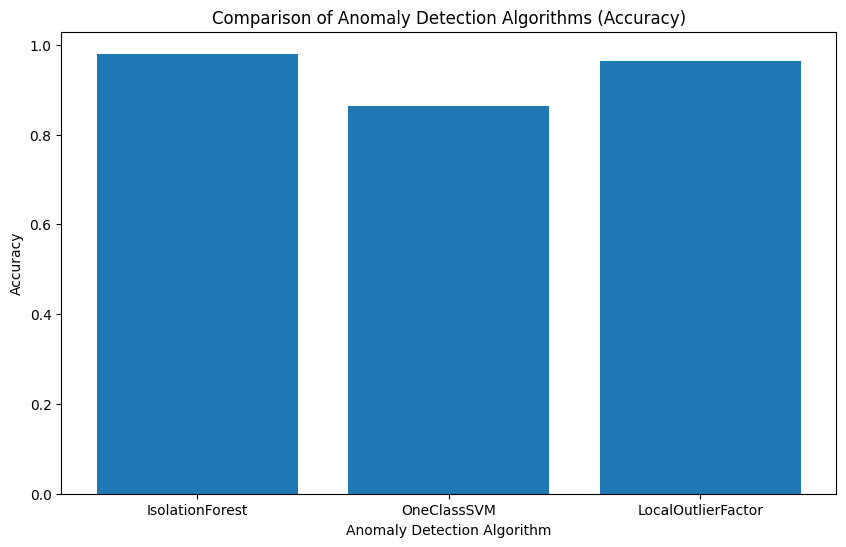

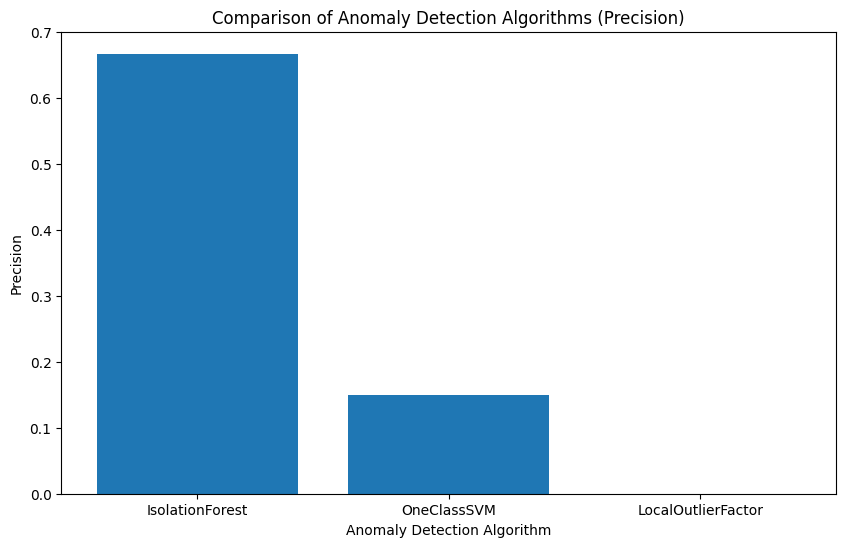

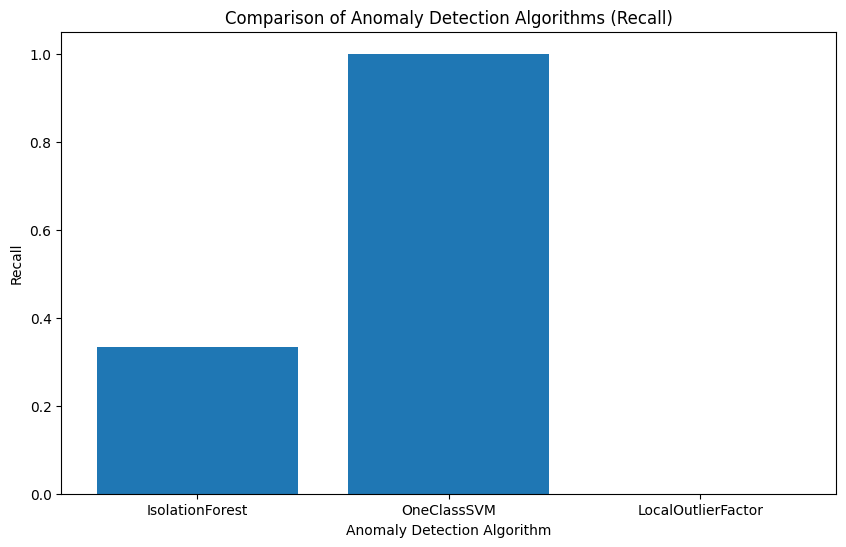

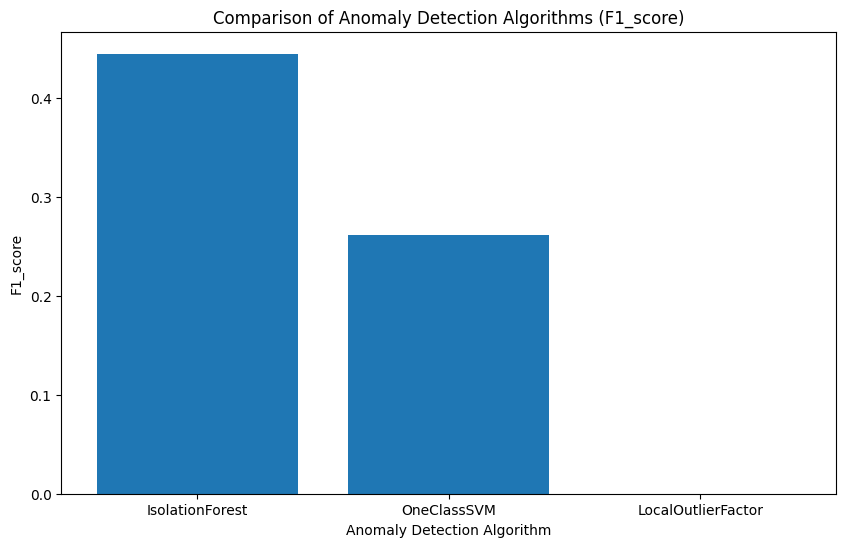

In [23]:
import matplotlib.pyplot as plt
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    scores = [result[metric] for result in anomaly_results.values()]
    plt.figure(figsize=(10, 6))
    plt.bar(anomaly_results.keys(), scores)
    plt.xlabel('Anomaly Detection Algorithm')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of Anomaly Detection Algorithms ({metric.capitalize()})')
    plt.show()

Exercise 8

In [ ]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt

# Load the "SA" subset of the dataset
D = fetch_kddcup99(subset='SA', as_frame=True)
data = D.frame

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Encode categorical features in X
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Standardize the features in X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode the target variable y
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Select the 5 most important features
selector = SelectKBest(mutual_info_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_features_indices = selector.get_support(indices=True)
print("Selected features indices:", selected_features_indices)

# Define anomaly detection algorithms
anomaly_algorithms = {
    'IsolationForest': IsolationForest(contamination=0.01, random_state=42),
    'OneClassSVM': OneClassSVM(nu=0.01, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
}

# Initialize Leave-One-Out cross-validation
loo = LeaveOneOut()

# Train and evaluate anomaly detection algorithms
anomaly_results = {}
for algo_name, algo in anomaly_algorithms.items():
    print(f"Evaluating {algo_name} with Leave-One-Out cross-validation...")
    
    y_true = []
    y_pred = []
    
    for train_index, test_index in loo.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if algo_name == 'LocalOutlierFactor':
            algo.fit(X_train)
            y_pred_test = algo.predict(X_test)
        else:
            algo.fit(X_train)
            y_pred_test = algo.predict(X_test)
        
        # Convert predictions from {-1, 1} to {0, 1}
        y_pred_test = np.where(y_pred_test == -1, 1, 0)
        y_true_test = np.where(y_test == 0, 0, 1)  # Assuming 0 is the label for 'normal'
        
        y_true.append(y_true_test[0])
        y_pred.append(y_pred_test[0])
    
    # Evaluate performance
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    anomaly_results[algo_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    print(f"{algo_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Compare the performance of the anomaly detection algorithms
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    scores = [result[metric] for result in anomaly_results.values()]
    plt.figure(figsize=(10, 6))
    plt.bar(anomaly_results.keys(), scores)
    plt.xlabel('Anomaly Detection Algorithm')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of Anomaly Detection Algorithms ({metric.capitalize()})')
    plt.show()

Selected features indices: [ 1  2  4 22 23]
Evaluating IsolationForest with Leave-One-Out cross-validation...


In [ ]:
# looking at the different output types
unique = data['labels'].unique() 
print(unique)